<a href="https://colab.research.google.com/github/svperbeast/ai_lab/blob/main/ai_lab_20201105_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Random seed to make results deterministic and reproducible
torch.manual_seed(0)

In [ ]:
# Problem 1
# Min-max scaler 를 구현하시오
# (x-min(x))/(max(x)-min(x))

# scaling function for input data
def minmax_scaler(data):
    return ((data - np.min(data, axis=0)) /
            (np.max(data, axis=0) - np.min(data, axis=0)) + 1e-8) # 1e-8 for avoiding divice by zero

# make dataset to train

In [ ]:
# make dataset to input
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]  # Next close price
        # print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

In [ ]:
# hyper parameters
seq_length = 7
data_dim = 5
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 500

In [ ]:
# load data
xy = np.loadtxt("data-02-stock_daily.csv", delimiter=",")
xy = xy[::-1]  # reverse order

# split train-test set
train_size = int(len(xy) * 0.7)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]

# scaling data
train_set = minmax_scaler(train_set)
test_set = minmax_scaler(test_set)

# make train-test dataset to input
trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

# convert to tensor
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

In [ ]:
# Problem 2
# LSTM과 fc layer로 이루어진 다음 Net을 구현하시오.
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(Net, self).__init__()
        self.rnn1 = torch.nn.LSTM(input_dim, hidden_dim,
                                 num_layers=layers, batch_first=True)
        self.rnn2 = torch.nn.LSTM(hidden_dim, hidden_dim*2,
                                 num_layers=layers, batch_first=True)
        self.fc1 = torch.nn.Linear(hidden_dim*2, hidden_dim*4, bias=True)
        self.fc2 = torch.nn.Linear(hidden_dim*4, hidden_dim*8, bias=True)
        self.fc3 = torch.nn.Linear(hidden_dim*8, output_dim, bias=True)

    def forward(self, x):
        x, _state = self.rnn1(x)
        x, _state = self.rnn2(x)
        x = torch.nn.functional.relu(self.fc1(x[:, -1]))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net(data_dim, hidden_dim, output_dim, 2)

In [ ]:
# loss & optimizer setting
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [ ]:
# Problem 3
# 다음 학습 과정을 구현하시오.

# start training
for i in range(iterations):
    optimizer.zero_grad()

    outputs = net(trainX_tensor)

    loss = criterion(outputs, trainY_tensor)
    loss.backward()

    optimizer.step()

    if i % 50 == 0:
      print('loss: {:.4f}'.format(loss.item()))

loss: 0.1728
loss: 0.0099
loss: 0.0037
loss: 0.0021
loss: 0.0015
loss: 0.0012
loss: 0.0012
loss: 0.0011
loss: 0.0011
loss: 0.0011


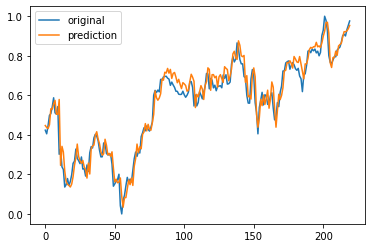

In [ ]:
plt.plot(testY)
plt.plot(net(testX_tensor).data.numpy())
plt.legend(['original', 'prediction'])
plt.show()